In [1]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
import momepy

/opt/miniconda3/envs/book/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Convert shapefile to graph
hghway = gpd.read_file("data/oregon_highways.shp")
graph = momepy.gdf_to_nx(hghway, approach="primal", directed=True)

/opt/miniconda3/envs/book/lib/python3.12/site-packages/pyogrio/raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured LineString' is converted to 'LineString'
  return ogr_read(


In [3]:
# Convert graph to gdf
nodes, edges = momepy.nx_to_gdf(graph)

In [4]:
# Provide an x and y for OSMnx
nodes['x'] = nodes['geometry'].x
nodes['y'] = nodes['geometry'].y

In [5]:
# Provide a u and v for OSMnx
edges['u'] = edges['node_start']
edges['v'] = edges['node_end']

In [6]:
# Make all roads "two-way"
opposite_direction = edges.copy()
opposite_direction = opposite_direction.rename(columns={"u": "v", "v": "u"})
directed_edges = pd.concat([edges, opposite_direction], ignore_index=True)

In [7]:
edges = directed_edges.set_index(['u', 'v'])

In [8]:
# Add a key index
doubles = edges[edges.index.duplicated()].copy()
singles = edges[~edges.index.duplicated()].copy()

singles['key'] = 0
doubles['key'] = 1

edges = pd.concat([singles, doubles])

In [9]:
# Make the multi-index
edges = edges.reset_index().set_index(['u', 'v', 'key'])

In [10]:
# Rename some columns
edges = edges[['HWYNAME','mm_len', 'geometry']]
edges = edges.rename(columns={"HWYNAME": "name", "mm_len": "length"})

In [11]:
# Convery back to graph
gdf = ox.graph_from_gdfs(nodes, edges)

In [12]:
# Save and load
ox.save_graphml(gdf, './data/graph.graphml')
graph = ox.load_graphml('./data/graph.graphml')

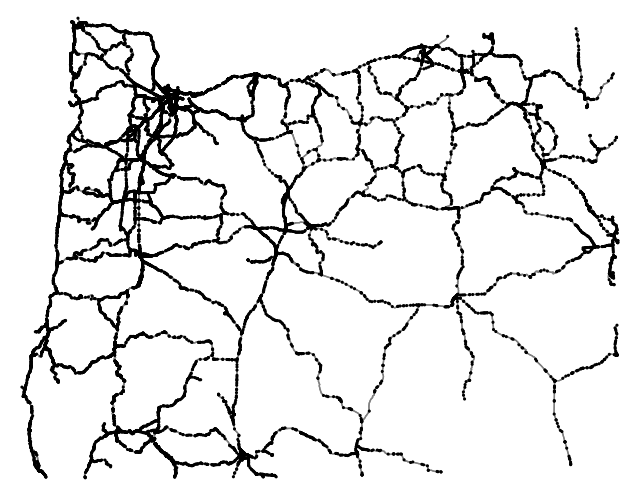

In [13]:
# Plot
fig, ax = ox.plot_graph(graph, bgcolor='white', node_color='black', edge_color='grey', node_size=5)